In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from numba import njit, f8, i8
from collections import namedtuple

# Gillespie Algorithm

We have $N$ chemical species $\{S_1,\cdots,S_n\}$ and $M$ chemical reactions between them $\{R_1,\cdots ,R_M\}$

$X_i(t)$ is the amount of molecules (or concentration) of $S_i$. The system is thus described by the vector $\vec x(t)=\{X_1(t),\cdots,X_N(t)\}$.


Each reaction $R_j$ has a state-change vector $\vec v_j = \{v_{1j},\cdots,v_{Nj}\}$, where the quantity $v_{ij}$ is the change that reaction $R_j$ produces on species $S_i$. If the system is in state $\vec x$, reaction $R_j$ changes this state to $\vec x + \vec v_j$.

Each reaction also has a "propensity function" $a_j(\vec x)$, where $a_j(\vec x) dt$ is the probability of the reaction $R_j$ occuring in the time interval $dt$.

The reaction rate equation is:

$$
\frac{d \vec X(t)}{dt} = \sum_{j=1}^M \vec v_j  a_j(\vec X(t))
$$

We define $p_j(\tau,\vec x)$ as the probability (given a state $\vec x$) that the next reaction is $R_j$ and it will occur in a $\tau$ interval. Apparently

$$
p_j(\tau,\vec x) = a_j(\vec x) \exp\left( -\tau a_0(\vec x)\right)
$$

Where $a_0(\vec x)$ is the sum of all the $a_j$s. 

Therefore the stochastic time between reactions is an exponential random varaible with mean $1/a_0(\vec x)$, and the reaction that occurs first can be picked from the $R_j$s with probabilities $a_j(\vec x)/a_0(\vec x)$.

If we include the time as first coordinate on the state vector, $\vec x=\{t,m,r\}$. $x_0=t$, the data can be stored more efficiently.

In [2]:
@njit
def random_choice(arr,probs):
    '''Sample elements of an array with specific probabilities. 
        `arr`: np.array, from which to sample. Possible n-dimensional
        `probs`: np.array, same size as `arr`. No need to sum up to 1.
    Returns a random sample from `arr`. 
    Sampling from a matrix will select from its rows.
    This function exists because numba does not support the `p` flag on `random.choice`. 
    See [https://github.com/numba/numba/issues/2539] for details.'''
    cummulative_probs = np.cumsum(probs)/np.sum(probs)
    index = np.searchsorted(cummulative_probs, np.random.random(), side="right")
    return arr[index]

@njit(f8[:](f8[:],i8))
def moving_average(arr, w):
    '''Moving average of 1D-array taking a definite number of neighbors.
        `a`: 1D-array. Data to take the moving average
        `w`: integer, window size, neighbors.
    Returns an array with the moving mean. Has size `len(arr)+1-w` because of course it does. 
    If you have a time series (times,values), applying this function to both will give you 
    the mean time series i.e. you can plot(moving_average(times,w),moving_average(values,w)). '''
    r = np.cumsum(arr)
    r[w:] = r[w:] - r[:-w]
    return r[w - 1:] / w

def GillespieModel(a_foo, v_foo):
    '''Generates an object to simulate the system with the Gillespie algorithm.
        `a_foo`: an NJIT-compiled function f8[:](f8[:]). 
            a_foo(x_vec) should give the a_j probabilities vector for the reactions.
        `v_foo`: an NJIT-compiled function f8[:,:](f8[:]). 
            v_foo(x_vec) should give the v_ij state-change matrix. 
            The first column of this matrix *must* be zeros.
    Returns an object with the functions:
        * step
        * single_system
        * multi_system
    The probability vector and state-change matrix are functions of the state. This is not true 
    in general, and its coded that way to provide flexibility. Perhaps excessive flexibility. 
    Explicit time-dependent state changes should be treated with care, as they lie outside of the 
    statistical considerations of Gillespie's work.
    '''
    # this is only notation for the object-oriented people.
    wrapper = namedtuple("GillespieModel",["step","single_system","multi_system"])

    @njit(f8[:](f8[:]))
    def step(x_ini):
        '''Evolves the system one step from the given initial state. 
            `x_ini`: 1D-array of floats with elements [time,S1,S2,...,SN]
        Returns the final state of the system, same length as `x_ini`.'''
        # generates probability array and state-change matrix
        a_arr = a_foo(x_ini)
        v_matrix = v_foo(x_ini)
        # choose randomly which reaction happens. v_j is the change on the state
        v_j = random_choice(v_matrix, a_arr)
        # as the time is the zeroth coordinate, generate a vector [dtau,0,0,...,0]
        tau = np.zeros_like(x_ini)
        tau[0] = np.random.exponential(1/np.sum(a_arr))
        # the change in state is the initial state, plus change in state, plus change in time.
        return x_ini + v_j + tau
    
    @njit(f8[:,:](f8[:],i8))
    def single_system(x_ini, max_iter):
        '''Evolves one system a definite number of iterations from the initial state. 
            `x_ini` is the same as in `step`.
            `max_iter`: integer, iteration number.
        Returns an array of states of length `max_iter`. 
        
        The relatinship between the final time and the number of iterations is not trivial, 
        as time intervals depend on the system states.'''
        states = np.zeros( (max_iter, len(x_ini)) )
        states[0] = x_ini
        for i in range(1,max_iter):
            states[i] = step(states[i-1])
        return states
        
    @njit(f8[:,:](f8[:,:],i8))
    def multi_system(x_ini_vec,max_iter):
        '''Evolves several systems at once a definite number of iterations.
            `x_ini_vec`: 2D-array of floats. Vector of inital states, one for each system.
            `max_iter`: integer, iteration number.
        Returns a matrix with columns [time,S1,S2,...,SN], with all the states of all the systems, 
        ordered in time, so the information of which data belongs to which system is lost.
        Data is clipped up to the minimum final time among the systems. This is done to avoid 
        statistic inaccuracies calculating mean values.'''
        n_systems = len(x_ini_vec)
        n_variables = len(x_ini_vec[0])
        simulations = np.zeros( (n_systems,max_iter,n_variables) )
        for i in range(n_systems):
            simulations[i] = single_system(x_ini_vec[i],max_iter)
        # reshape data to a big matrix
        data = simulations.reshape(n_systems*max_iter,n_variables)
        # order the data with respect to the first column (time)
        data = data[np.argsort(data.T[0])] 
        # return data up to the time when the first system ended its simulation
        systems_last_times = simulations[:,-1].T[0]
        t_limit = np.min(systems_last_times)
        mask = data.T[0] <= t_limit
        
        return data[mask]
    
    
    return wrapper(step, single_system, multi_system)

## mARN and protein simple model example

In [3]:
cm = 1.0
dm = 0.2
cp = 50
dp = 0.03333333

@njit(f8[:](f8[:]))
def a(x_vec):
    return np.array([cm, dm*x_vec[1], cp*x_vec[1], dp*x_vec[2]])

@njit(f8[:,:](f8[:]))
def v(x_vec):
    # first column *must* be zeros
    return np.array([
        [0.,  1.,  0.], # creation of mRNA
        [0., -1.,  0.], # degradation of mRNA
        [0.,  0.,  1.], # creation of protein
        [0.,  0., -1.], # degradation of protein
    ])

In [4]:
%time model = GillespieModel(a,v)

CPU times: user 6.57 s, sys: 12.4 ms, total: 6.58 s
Wall time: 6.6 s


In [5]:
# one system, one step
%timeit model.step(np.array([0.,0.,0.]))

6.26 µs ± 457 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
# one system, 60k steps
%timeit model.single_system(np.array([0.,0.,0.]),60_000)

82.2 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# 100 systems, 60k steps, take 1 of each 100 of the data to avoid eating up RAM
%time ts,ms,ps = model[2](np.zeros((100,3)),60_000)[::100].T

CPU times: user 8.92 s, sys: 265 ms, total: 9.19 s
Wall time: 9.17 s


### All simulations, means and stds bands

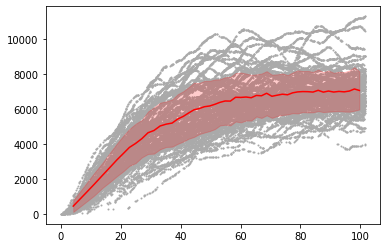

In [8]:
w = 800

tmeans = np.mean(np.reshape(ts[:(len(ts)//w)*w],(len(ts)//w,w)),axis=1)
pmeans = np.mean(np.reshape(ps[:(len(ts)//w)*w],(len(ts)//w,w)),axis=1)
pstds = np.std(np.reshape(ps[:(len(ts)//w)*w],(len(ts)//w,w)),axis=1)

plt.scatter(ts,ps,s=1,c='#aaa')
plt.plot(tmeans,pmeans,c='r')
plt.fill_between(tmeans,pmeans-pstds,pmeans+pstds,color='r',alpha=0.2)

### Noise

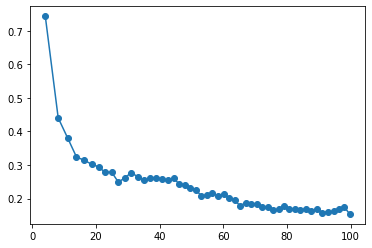

In [9]:
plt.plot(tmeans,pstds/pmeans,"-o")